In [1]:
import numpy as np
import matplotlib.pyplot as plt

import pcms.haar as haar

## Part 1: verify functionality

In [2]:
n_leaves = 100
func = np.random.dirichlet(alpha=np.ones((n_leaves,), dtype=float))
y = 136

In [3]:
cdf_val = haar.cdf_rand_basis(y, func, eps=0.01, delta=0.01)

In [4]:
print(cdf_val)

0.9368527072613679


In [5]:
n_points = 1000
ys = np.linspace(0.1, 140, n_points)

In [6]:
cdf_vals = haar.cdf_rand_basis(ys, func, eps=0.01, delta=0.01)

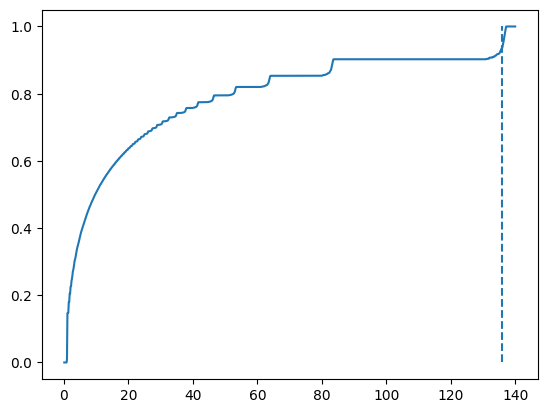

In [7]:
plt.plot(ys, cdf_vals)
plt.vlines(y, 0, 1, linestyles='--')
plt.show()

In [8]:
pdf_vals = np.gradient(cdf_vals, ys)

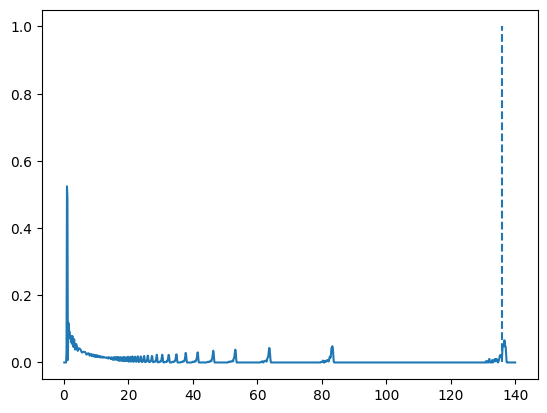

In [9]:
plt.plot(ys, pdf_vals)
plt.vlines(y, 0, 1, linestyles='--')
plt.show()